### Setting

In [4]:
from gnews import GNews

import pandas as pd

from datetime import date, timedelta

import os
import re
import ast

### Crawler

In [5]:
google_news = GNews(language='en', country='US', period='1d')

start_date = date(2020, 1, 1)
end_date = date(2020, 1, 2)

news_info = []
empty_list = [] # 뉴스가 하나도 없는 날짜

excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'
current_month = start_date.month

while start_date <= end_date:
    google_news.start_date = start_date
    google_news.end_date = start_date + timedelta(days=1)  # Set end date as the next day of start date
    
    news = google_news.get_news('tesla')
    
    print(f"크롤링 중인 날짜: {start_date}:", start_date,'해당 날짜에 뉴스 갯수',len(news))

    if len(news) == 0:  # 뉴스가 하나도 없는 날
        empty_list.append(start_date)

    for article in news:
        news_info.append([article['publisher'], article['published date'], article['title'], article['description']])

    # 달이 변경되면 
    if start_date.month != current_month:
        df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
        df.to_excel(excel_file, index=False)
        
        news_info = []  # 리스트를 초기화합니다.
        current_month = start_date.month
        excel_file = f'news_data_{start_date.year}_{start_date.month}.xlsx'  # 새로운 엑셀 파일 이름을 설정합니다.

    start_date += timedelta(days=1)  # Increment start date by one day

df = pd.DataFrame(news_info, columns=['Publisher', 'Date', 'Title', 'Description'])
df.to_excel(excel_file, index=False)

print("뉴스가 하나도 없는 날 : ", empty_list)

C:\Users\HanGeunHyeong\AppData\Local\Temp\ipykernel_19196\3426767368.py:16: UserWarning: 
Period (1d) will be ignored in favour of the start and end dates
  news = google_news.get_news('tesla')


크롤링 중인 날짜: 2020-01-01: 2020-01-01 해당 날짜에 뉴스 갯수 6
크롤링 중인 날짜: 2020-01-02: 2020-01-02 해당 날짜에 뉴스 갯수 21
뉴스가 하나도 없는 날 :  []


In [6]:
df.head()

,Publisher,Date,Title,Description
0,"{'href': 'https://www.theguardian.com', 'title...","Thu, 02 Jan 2020 08:00:00 GMT",Tesla may have been on Autopilot in California...,Tesla may have been on Autopilot in California...
1,"{'href': 'https://carbuzz.com', 'title': 'CarB...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla Cybertruck Makes Music Video Debut - Car...,Tesla Cybertruck Makes Music Video Debut CarBuzz
2,"{'href': 'https://carbuzz.com', 'title': 'CarB...","Wed, 01 Jan 2020 08:00:00 GMT",All-New Tesla Model S Could Look Like This - C...,All-New Tesla Model S Could Look Like This Ca...
3,"{'href': 'https://en.globes.co.il', 'title': '...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla setting up Israel R&D office - Globes - ...,Tesla setting up Israel R&D office - Globes G...
4,"{'href': 'https://electrek.co', 'title': 'Elec...","Wed, 01 Jan 2020 08:00:00 GMT",Tesla updates 2020 Supercharger map with new l...,Tesla updates 2020 Supercharger map with new l...


### Data Transformation

In [7]:
# 데이터가 있는 디렉토리
data_dir = "C:/Users\HanGeunHyeong/Desktop/StockPredictionByTextMining/Dataset/Crawler_dataset/Monthly"
output_dir = "C:/Users\HanGeunHyeong/Desktop/StockPredictionByTextMining/Dataset"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

all_data = pd.DataFrame()

for filename in sorted(os.listdir(data_dir)):
    file_path = os.path.join(data_dir, filename)
    
    if not filename.endswith('.xlsx'):
        continue

    df = pd.read_excel(file_path)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y.%m.%d')

    # 'Publisher' 컬럼의 'title' 값만 추출
    df['Publisher'] = df['Publisher'].apply(lambda x: ast.literal_eval(x)['title'] if pd.notnull(x) else x)

    # 'Title' 컬럼에서 'Publisher' 값을 제거
    df['Title'] = df.apply(lambda row: row['Title'].replace(row['Publisher'], '').strip(), axis=1)

    # 'Description' 컬럼에서 'Publisher' 값을 제거
    df['Description'] = df.apply(lambda row: row['Description'].replace(row['Publisher'], '').strip() if pd.notnull(row['Description']) else row['Description'], axis=1)

    # 'Description' 컬럼의 값에서 영어가 아닌 문자 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

    # 'Description' 컬럼의 값에서 영어가 아닌 한자, 한국어, 일본어 등 제거
    df['Description'] = df['Description'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

    # 'Date' 컬럼으로 그룹화하고 'Publisher'와 'Description' 컬럼을 각각 합침
    df_consolidated = df.groupby(['Date']).agg({'Publisher': ' '.join, 'Description': ' '.join}).reset_index()

    # 그룹의 크기를 나타내는 'News_Count'라는 열을 추가
    df_consolidated['News_Count'] = df.groupby(['Date']).size().values

    # 모든 데이터를 저장하는 데이터프레임에 추가
    all_data = all_data._append(df_consolidated, ignore_index=True)

In [8]:
# 'Date' 컬럼을 datetime 형식으로 변환
all_data['Date'] = pd.to_datetime(all_data['Date'])

# 날짜에서 요일을 추출 (월요일: 0, 일요일: 6)
all_data['weekday'] = all_data['Date'].dt.weekday

# 요일이 토요일(5), 일요일(6)인 경우 그 다음 월요일로 변경한 날짜를 'group_date'라는 새로운 컬럼에 저장
all_data['group_date'] = all_data.apply(lambda row: row['Date'] + pd.DateOffset(days=(7 - row['weekday'])) if row['weekday'] in [5, 6] else row['Date'], axis=1)

# 'group_date' 컬럼의 이름을 'Date'로 변경
all_data.rename(columns={'group_date': 'new_date'}, inplace=True)

In [9]:
# 'Date' 컬럼으로 그룹화하여 'Publisher', 'Description', 'News_Count' 컬럼의 값들을 합침
all_data_grouped = all_data.groupby(['new_date']).agg({'Publisher': ' '.join, 'Description': ' '.join, 'News_Count': 'sum'}).reset_index()
all_data_grouped = all_data_grouped.sort_values(by=["new_date"], ascending=[True]) 
all_data_grouped = all_data_grouped[all_data_grouped['new_date'] <= '2022-12-31']

# 결과를 엑셀 파일로 저장
all_data_grouped.to_excel(os.path.join(output_dir, "data_transformation.xlsx"), index=False)

In [10]:
all_data_grouped.head()

,new_date,Publisher,Description,News_Count
0,2020-01-01,CarBuzz CarBuzz Globes Electrek,Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,The Guardian Gulf News TechCrunch Reuters Inve...,Tesla may have been on Autopilot in California...,21
2,2020-01-03,Khmer Times Khmer Times Fossbytes CNBC The Ver...,Tesla to provide movies online games in its ca...,27
3,2020-01-06,Terre Haute Tribune Star Mashable CarScoops In...,I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,CNBC ISRAEL21c USA TODAY Fossbytes QN Motori F...,China could be the swing factor for Teslas sto...,27


### Data Preprocessing

#### Setting

In [11]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stopwords_default = stopwords.words('english')
custom_stop_words = set(ENGLISH_STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HanGeunHyeong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HanGeunHyeong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HanGeunHyeong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# 추가적인 불용어 카테고리별로 설정
general_stopwords = ['with', 'was', 'will', 'why', 'what', 'you', 'your', 'who', 'yet', 'years', 'world', 'working', 'work', 'we', 'when']
brand_stopwords = ['tesla', 'volvo', 'volkswagen', 'xpeng']
tech_stopwords = ['video', 'updates', 'youtuber', 'youtube', 'windows', 'wifi', 'wireless', 'watching', 'watch', 'windowbreaking', 'window', 'wing']
car_stopwords = ['vehicles', 'truckers', 'transportation', 'trucks', 'vehicle']
date_stopwords = ['january', 'fabruary', 'march','april','may','june','july','agust','september','october','november','december']
other_stopwords = ['do']

all_additional_stopwords = general_stopwords + brand_stopwords + tech_stopwords + car_stopwords+date_stopwords + other_stopwords

for stopword in all_additional_stopwords:
    stopwords_default.append(stopword)


# 전처리 : 표제어 + 불용어 적용 안되는 것
noun_words = ['beans', 'murphy','rockets',
              'producevehicle','games','airlines','operators','facilities',
              'videos','claims','masks','nations','vehicles','ploblems','photos',
              'sits','relations','covers','hands','tensions','capabilities','nations','requests','endorsements',
              'teams', 'ploblems','areas','streets','signs','possiblities','workers','sales','adopters','developments',
              'companies','clubs','dashboards','powerwalls','panalties','challenges','tasks','machines','households',
              'negotiations','politics','overseas','homeowners','wars','movies','autospies','paneles','withdraws',
              'margins','automakers','nuevos','flaws','deepfakes','believers','angeles','spacers','deliveries','fails']
verb_words = ['have','waived','involving','abundoning','contribute','engaged','recalled','intensifying','led','curves',
              'received', 'charges', 'investigating', 'intensifying', 'said','retreating','considering','remains','began','displayed',
              'fired','lined','depanding','blamed','killing','sitting','opted','enticing','reviewing','contends','missed','balancing',
              'anticipated','jumped','delievered','shifted','killed','concerning','arrived','defects','argued','disclosed',
              'explained','appears','stopped','depending','battered','thinking','pressured','slowing','tumbling','tensifying',
              'explained','restarts','admitted','demands','totaled','demonstrates','opposing','interested','acting','taken','braking',
              'peaking','dethroned','met','guessed','developer','outstanding','performing','loaded','rides','launched','allows',
              'thrilled','operated','refusing','slumped','affected','appeared','removing','saying','related','troubled',
              'advanced','raised','killed','defects','crewed','performing','leaving','got','explains','raising',
              'inspires','injured','sales','powered','pulled','cutting','fleeing','creating','growing','coming',
              'leasing','promising','revealed','nailed','did','linking','tuned','optimizes','badged',
              'receives','patched','encourageing','thought','recommends','combined','endangered','counterfeiting',
              'challenging','owned','missing','creates','closing','won','hinting','billing','rolling','nears','breaking','given',
              'commemorating','receiving','going','targeted','kicking','replaced','seeking','promotes','taking',
              'stealing','spotted','celebrating','extended','preserving','allows','cutting','including','positioning',
              'extends','enabled','fixing','replacing','promotes','sends','flying','replanting','responds','rumoured',
              'installed','inspired','isolating','designed','earnings','jolted','adding','picking','running','rolls',
              'acquires','electrifying','sustaining','redesigned','committed','branded','launched','prepares','worked',
              'zoomed','shares','earnings','confirmed','making', 'makes','abandoning','abandoned','abandons','delievering',
              'replaces','sent','says']
adject_words = ['nearest','safer','older','worse','slower','lower','hottest','coolest','effectively','originally','cheaper']

In [13]:
tsla_df = all_data_grouped.copy()
tsla_df.rename(columns={'new_date':'Date'}, inplace = True)
tsla_df.head()

,Date,Publisher,Description,News_Count
0,2020-01-01,CarBuzz CarBuzz Globes Electrek,Tesla Cybertruck Makes Music Video Debut AllNe...,4
1,2020-01-02,The Guardian Gulf News TechCrunch Reuters Inve...,Tesla may have been on Autopilot in California...,21
2,2020-01-03,Khmer Times Khmer Times Fossbytes CNBC The Ver...,Tesla to provide movies online games in its ca...,27
3,2020-01-06,Terre Haute Tribune Star Mashable CarScoops In...,I70 crash one of 3 raising questions about Tes...,45
4,2020-01-07,CNBC ISRAEL21c USA TODAY Fossbytes QN Motori F...,China could be the swing factor for Teslas sto...,27


In [14]:
# preprocessing function - stem 여부(?)
def preprocess_word(text):

    text = text.lower()
    words = re.findall(r'\b[a-zA-Z]+\b', text)

    preprocessed_sentence = ' '.join([word for word in words if word not in stopwords_default])

    tokens = nltk.word_tokenize(preprocessed_sentence)

    ## 표제어 추출
    # noun_words의 단어를 명사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='n') if word in noun_words else word for word in tokens]
    # verb_words의 단어를 동사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='v') if word in verb_words else word for word in tokens]
    # adject_words의  단어를 형용사로 표제어 추출
    tokens = [lemmatizer.lemmatize(word, pos='a') if word in adject_words else word for word in tokens]

    return ' '.join(tokens)

In [15]:
tsla_df['corpus'] = tsla_df['Description'].apply(preprocess_word)

In [16]:
tsla_df.head()

,Date,Publisher,Description,News_Count,corpus
0,2020-01-01,CarBuzz CarBuzz Globes Electrek,Tesla Cybertruck Makes Music Video Debut AllNe...,4,cybertruck make music debut allnew model could...
1,2020-01-02,The Guardian Gulf News TechCrunch Reuters Inve...,Tesla may have been on Autopilot in California...,21,autopilot california crash kill two stop cyber...
2,2020-01-03,Khmer Times Khmer Times Fossbytes CNBC The Ver...,Tesla to provide movies online games in its ca...,27,provide movie online game cars unique bootleg ...
3,2020-01-06,Terre Haute Tribune Star Mashable CarScoops In...,I70 crash one of 3 raising questions about Tes...,45,crash one raise questions teslas autopilot tes...
4,2020-01-07,CNBC ISRAEL21c USA TODAY Fossbytes QN Motori F...,China could be the swing factor for Teslas sto...,27,china could swing factor teslas stock first mo...


In [17]:
def str_to_list(char):
    return list(set(list(char.split(" "))))
    
tsla_df['Publisher'] = tsla_df['Publisher'].apply(str_to_list)

In [18]:
tsla_df.to_csv(os.path.join(output_dir, "preprocessed_data.csv"), index=False)

### Text Vectorization

#### Setting

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter

from wordcloud import WordCloud
import matplotlib.pyplot as plt


from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, normalize


from wordcloud import WordCloud

%matplotlib inline

In [20]:
# 뉴스 데이터 가져오기

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(tsla_df['corpus'])
feature_names = tfidf_vectorizer.get_feature_names_out()


# 단어 목록을 행으로 하는 tfidf 행렬
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df.shape

(781, 20272)

#### word -featuring : 분석에 사용할 키워드 갯수 정하기

In [21]:
# visualization function
def plot_keywords(x, y, y_label, title):

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10,6))

    plt.plot(x, y,  marker='o', color = 'b')

    plt.gca().invert_xaxis()

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().set_facecolor('lightgray')
    plt.grid(color='white', linestyle='-', linewidth=1)

    k_formatter = FuncFormatter(lambda x, pos: f'K{x}')
    plt.gca().xaxis.set_major_formatter(k_formatter)

    plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

    plt.xlabel('Number of selected top keywords from each data')
    plt.ylabel(y_label)

    # for i in [3, 4, 5]:
    #     if i in x:
    #         index = x.index(i)
    #         plt.plot(i, y[index], marker='o', color='y')

    plt.title(title)
    plt.show()

keyword_counts = list(range(20, 1, -1))
tfidf_matrix_transposed = tfidf_matrix.toarray()

#### Metric 1 : Mean of the TF-IDF scores of a word-feature across data

C:\Users\HanGeunHyeong\AppData\Local\Temp\ipykernel_19196\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


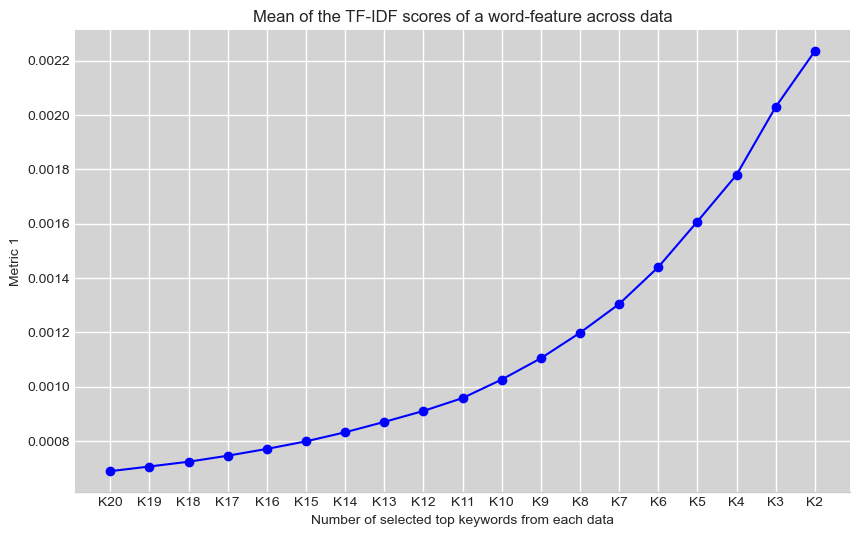

In [22]:
mean_tfidf_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])
    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()

    # TF-IDF score 평균 계산
    mean_tfidf_score = np.mean(keyword_tfidf_scores)
    mean_tfidf_scores.append(mean_tfidf_score)

plot_keywords(keyword_counts, mean_tfidf_scores, 'Metric 1',  'Mean of the TF-IDF scores of a word-feature across data')

#### Metric 2 : Mean of the cosine similarities of a word-feature to other features


C:\Users\HanGeunHyeong\AppData\Local\Temp\ipykernel_19196\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


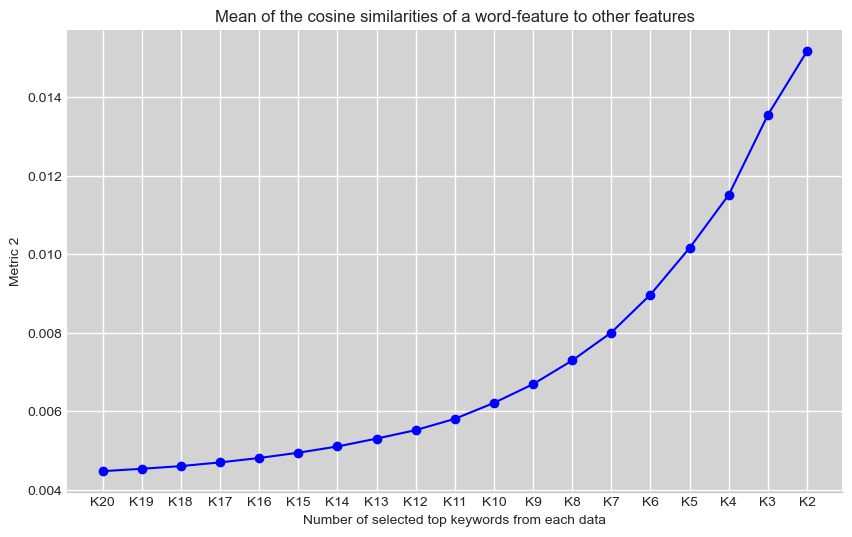

In [23]:
mean_cosine_similarities = []

for num_keywords in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-num_keywords:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].T
    cosine_similarities = cosine_similarity(keyword_matrix)

    mean_cosine_similarity = np.mean(cosine_similarities)
    mean_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, mean_cosine_similarities,'Metric 2', 'Mean of the cosine similarities of a word-feature to other features')

#### Metric 3 : Cosine similarity between a word-feature and the centroid of features

C:\Users\HanGeunHyeong\AppData\Local\Temp\ipykernel_19196\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


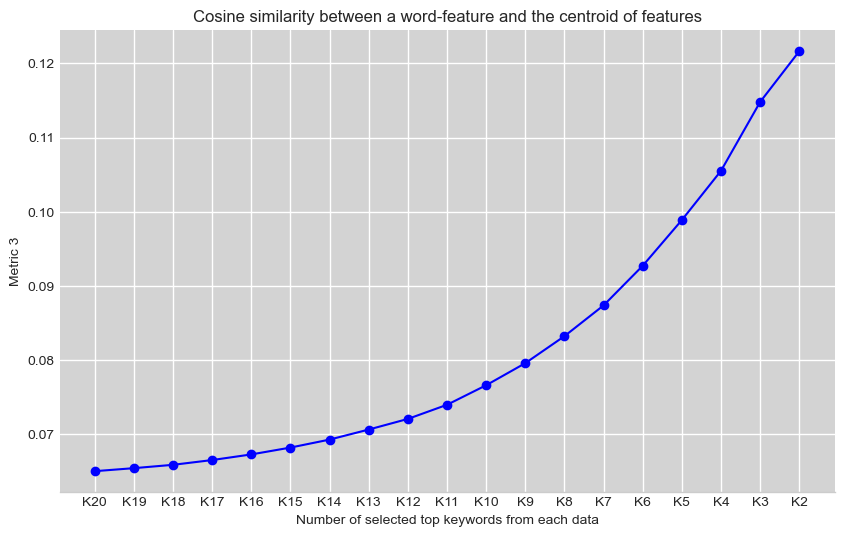

In [24]:
median_cosine_similarities = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices]

    keyword_matrix = keyword_matrix.T.toarray()

    centroid = np.mean(keyword_matrix, axis=0)
    centroid = np.asarray(centroid).reshape(1, -1)

    cosine_similarities = []

    for idx in range(keyword_matrix.shape[0]):
        word_vector = keyword_matrix[idx, :]
        word_vector = np.asarray(word_vector).reshape(1, -1)
        cosine_similarity_value = cosine_similarity(word_vector, centroid)
        cosine_similarities.append(cosine_similarity_value[0][0])


    mean_cosine_similarity = np.mean(cosine_similarities)
    median_cosine_similarities.append(mean_cosine_similarity)

plot_keywords(keyword_counts, median_cosine_similarities, "Metric 3", "Cosine similarity between a word-feature and the centroid of features")

#### Metric 4 : Mean of the dot product scores of a word-feature to other features

C:\Users\HanGeunHyeong\AppData\Local\Temp\ipykernel_19196\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


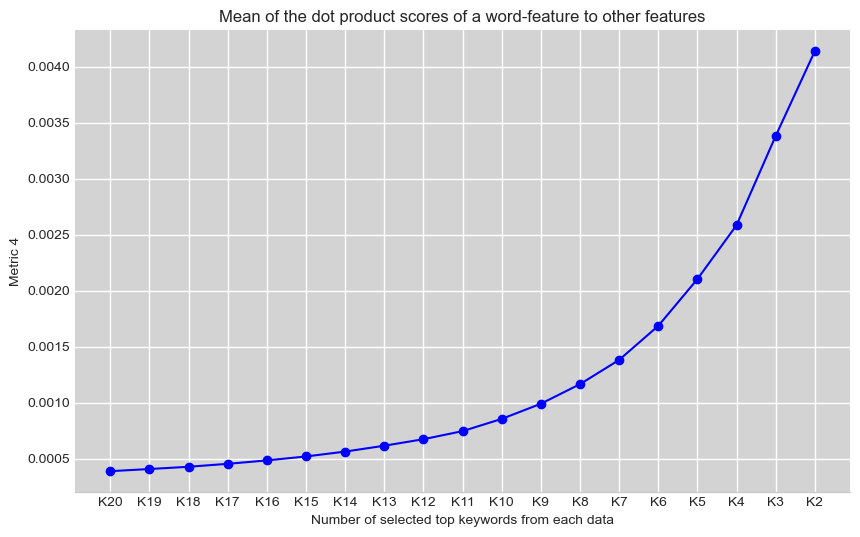

In [25]:
mean_dot_product_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))

    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_tfidf_scores = tfidf_matrix[:, keyword_indices].toarray()
    dot_product_scores = np.dot(keyword_tfidf_scores.T, keyword_tfidf_scores)

    mean_dot_product_score = np.mean(dot_product_scores)
    mean_dot_product_scores.append(mean_dot_product_score)

plot_keywords(keyword_counts, mean_dot_product_scores,"Metric 4", "Mean of the dot product scores of a word-feature to other features")

#### Metric 5 : LDA score of a word-feature for the single topic of entire data set

C:\Users\HanGeunHyeong\AppData\Local\Temp\ipykernel_19196\578327706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


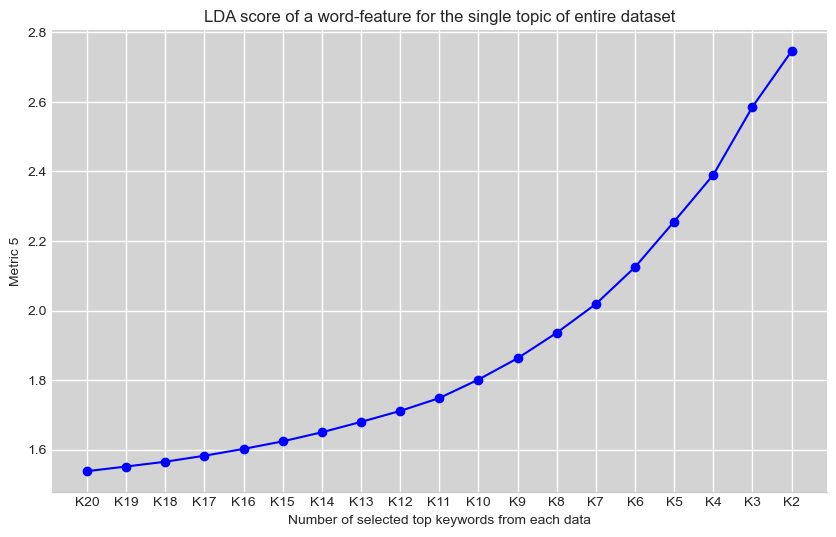

In [26]:
mean_lda_scores = []

for count in keyword_counts:
    top_keywords = []

    for doc_idx in range(len(df)):
        tfidf_scores = tfidf_matrix[doc_idx].toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-count:]
        top_keywords.extend([feature_names[idx] for idx in top_indices])

    top_keywords = list(set(top_keywords))
    keyword_indices = [np.where(np.array(feature_names) == keyword)[0][0] for keyword in top_keywords]
    keyword_matrix = tfidf_matrix[:, keyword_indices].toarray()

    num_topics = 1
    lda_model = LatentDirichletAllocation(n_components=num_topics)
    lda_model.fit(keyword_matrix)

    lda_scores = lda_model.components_

    mean_lda_score = np.mean(lda_scores)
    mean_lda_scores.append(mean_lda_score)

plot_keywords(keyword_counts, mean_lda_scores,"Metric 5", "LDA score of a word-feature for the single topic of entire dataset")

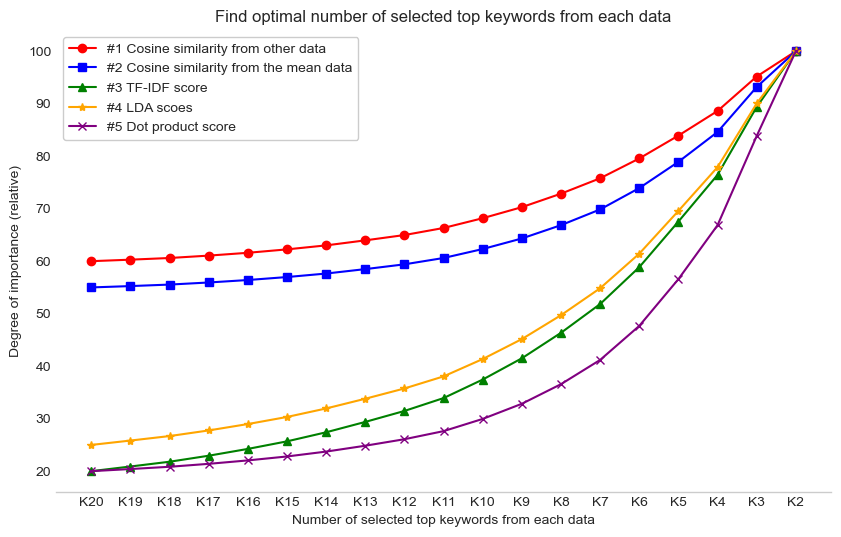

In [27]:
metric1_values = median_cosine_similarities
metric2_values = mean_cosine_similarities
metric3_values = mean_tfidf_scores
metric4_values = mean_lda_scores
metric5_values = mean_dot_product_scores

metric1_normalized = (metric1_values - np.min(metric1_values)) / (np.max(metric1_values) - np.min(metric1_values)) * 40 + 60
metric2_normalized = (metric2_values - np.min(metric2_values)) / (np.max(metric2_values) - np.min(metric2_values)) * 45 + 55
metric3_normalized = (metric3_values - np.min(metric3_values)) / (np.max(metric3_values) - np.min(metric3_values)) * 80 + 20
metric4_normalized = (metric4_values - np.min(metric4_values)) / (np.max(metric4_values) - np.min(metric4_values)) * 75 + 25
metric5_normalized = (metric5_values - np.min(metric5_values)) / (np.max(metric5_values) - np.min(metric5_values)) * 80 + 20

# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10,6))

plt.gca().invert_xaxis()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().set_facecolor('lightgray')

plt.xticks(range(min(keyword_counts), max(keyword_counts)+1))

k_formatter = FuncFormatter(lambda x, pos: f'K{x}')

plt.gca().xaxis.set_major_formatter(k_formatter)
plt.grid(color='white', linestyle='-', linewidth=1)
plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')

plt.plot(keyword_counts, metric1_normalized, marker='o', label='#1 Cosine similarity from other data', color='red')
plt.plot(keyword_counts, metric2_normalized, marker='s', label='#2 Cosine similarity from the mean data', color='blue')
plt.plot(keyword_counts, metric3_normalized, marker='^', label='#3 TF-IDF score', color='green')
plt.plot(keyword_counts, metric4_normalized, marker='*', label='#4 LDA scoes', color='orange')
plt.plot(keyword_counts, metric5_normalized, marker='x', label='#5 Dot product score', color='purple')

plt.xlabel('Number of selected top keywords from each data')
plt.ylabel('Degree of importance (relative)')
plt.title('Find optimal number of selected top keywords from each data')
plt.legend(frameon = True, framealpha=1)

plt.show()

In [28]:
all_keywords = []
top_keywords_per_document = []
feature_names = tfidf_vectorizer.get_feature_names_out()

for i in range(len(df)):
    tfidf_scores = zip(feature_names, tfidf_matrix[i].toarray()[0])
    sorted_tfidf_scores = sorted(tfidf_scores,key=lambda x: x[1], reverse=True)

    top_keywords_per_document.append([keyword for keyword,_ in sorted_tfidf_scores[:5]])

all_keywords=[keyword for document in top_keywords_per_document for keyword in document]

vectorizer = TfidfVectorizer(vocabulary=list(set(all_keywords)))
tfidf_matrix = vectorizer.fit_transform(tsla_df['corpus'])

print("현재 News 갯수:",tfidf_matrix.shape[0])
print("현재 word-feature 갯수:",tfidf_matrix.shape[1])

현재 News 갯수: 781
현재 word-feature 갯수: 1884


In [32]:
print("현재 News 갯수:",tfidf_matrix.shape[0])
print("현재 word-feature 갯수:",tfidf_matrix.shape[1])

현재 News 갯수: 781
현재 word-feature 갯수: 1884


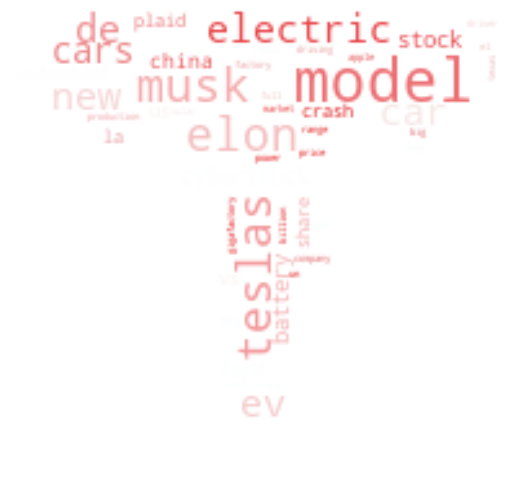

In [31]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# 워드 클라우드 생성 함수

mask = np.array(Image.open('C:/Users\HanGeunHyeong/Desktop/StockPredictionByTextMining/Dataset/logo.jpg'))

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=list(set(all_keywords)))
average_tfidf = tfidf_df.mean()
average_tfidf_dict = average_tfidf.to_dict()

# 워드 클라우드 생성
image_colors = ImageColorGenerator(mask)

wordcloud = WordCloud(
                      background_color="white",
                      mode="RGBA",
                      mask = mask).generate_from_frequencies(average_tfidf_dict)

image_colors = ImageColorGenerator(mask)

plt.axis('off')
plt.tight_layout(pad=0)

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")

In [33]:
### 키워드 추출 ###

# 문장에서 상위 max_keywords 만큼 키워드 추출 함수
def extract_keywords(sentence, all_keywords, max_keywords=None):
    # 문장에서 단어의 tfidf값 확인
    tfidf_values = vectorizer.transform([sentence]).toarray()[0]
    # tfidf값 기준으로 상위 max_keywords 만큼 스플릿
    sorted_indices = tfidf_values.argsort()[-max_keywords:][::-1]
    # 키워드의 인덱스로 키워드 확인
    keywords = [all_keywords[idx] for idx in sorted_indices]
    return ', '.join(keywords)

# 문장을 벡터화하여 모든 키워드 추출
all_keywords = tfidf_vectorizer.get_feature_names_out()

### 날짜별 키워드 추출 ###

# extract_keywords 함수를 이용해 날짜별 뉴스의 키워드 10개 추출
keywords_per_date_sentence = [extract_keywords(sentence, all_keywords, max_keywords=5)  for sentence in tsla_df['corpus']]

# 날짜, 키워드 데이터 생성
temp_df = pd.DataFrame({
    'Date': tsla_df['Date'],
    'Keywords' : keywords_per_date_sentence
})

In [192]:
temp_df

,Date,Keywords
0,2020-01-01,"angajai, biswa, americk, amerika, amerikaanse"
1,2020-01-02,"bets, autodief, allowed, bei, atelle"
2,2020-01-03,"baldwin, admit, acqua, banket, behold"
3,2020-01-06,"alcanzan, audis, bdzie, atrapar, alm"
4,2020-01-07,"besoin, appscooter, affirm, announcement, agl"
...,...,...
776,2022-12-26,"alleged, avano, batteries, bij, alimentaire"
777,2022-12-27,"amounts, aqui, adas, accessory, balyor"
778,2022-12-28,"automated, aspires, bisa, auctioned, ambulance"
779,2022-12-29,"attendees, autographs, assim, batterymakers, b..."


In [193]:
### 감성분석 ###
from collections import defaultdict

# 감성분석 점수 및 키워드를 저장할 딕셔너리 초기화
description_sentiment_scores = defaultdict(float)
keywords_sentiment_scores = defaultdict(float)
keywords_dict = defaultdict(list)

# 감성 단어 개수를 저장할 딕셔너리 초기화
description_uncertainty_count = defaultdict(int)
description_litigious_count = defaultdict(int)
description_constraining_count = defaultdict(int)
description_superfluous_count = defaultdict(int)
description_weakmodal_count = defaultdict(int)
description_positive_count = defaultdict(int)
description_negative_count = defaultdict(int)

keywords_uncertainty_count = defaultdict(int)
keywords_litigious_count = defaultdict(int)
keywords_constraining_count = defaultdict(int)
keywords_superfluous_count = defaultdict(int)
keywords_weakmodal_count = defaultdict(int)
keywords_positive_count = defaultdict(int)
keywords_negative_count = defaultdict(int)

# Loughran-McDonald 사전 로드
sentiment_df = pd.read_csv('C:/Users\HanGeunHyeong/Desktop/StockPredictionByTextMining/Dataset/LM-SA-2020.csv')

# 감성별 사전 초기화
uncertainty_dict = defaultdict(int)
litigious_dict = defaultdict(int)
constraining_dict = defaultdict(int)
superfluous_dict = defaultdict(int)
weakmodal_dict = defaultdict(int)
positive_dict = defaultdict(int)
negative_dict = defaultdict(int)

for _, row in sentiment_df.iterrows():
    word, sentiment = row['word'], row['sentiment']
    if sentiment == 'Uncertainty':
        uncertainty_dict[word] = 1
    elif sentiment == 'Litigious':
        litigious_dict[word] = 1
    elif sentiment == 'Constraining':
        constraining_dict[word] = 1
    elif sentiment == 'Superfluous':
        superfluous_dict[word] = 1
    elif sentiment == 'WeakModal':
        weakmodal_dict[word] = 1
    elif sentiment == 'Positive':
        positive_dict[word] = 1
    elif sentiment == 'Negative':
        negative_dict[word] = -1

In [194]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

# 감성 분석 함수
def sentiment_analysis(sentence, sentiment_dict):
    words = sentence.split()
    sentiment_score = sum(sentiment_dict[word] for word in words if word in sentiment_dict)
    return sentiment_score

# 감성 단어 개수를 세는 함수
def count_sentiment_words(sentences, sentiment_dict):
    words = sentences.split()
    
    count = 0
    count += sum(1 for word in words if word in sentiment_dict)
    
    return count

all_data = tsla_df.copy()
all_data['Keywords'] = temp_df['Keywords']

# 날짜별로
for i, row in all_data.iterrows():
    date = row['Date']
    descriptions  = row['corpus']
    
    keywords = row['Keywords']

    # 감성분석 점수 계산 (키워드의 감성 점수 합)
    keywords_sentiment_scores[date] = sum(sentiment_analysis(str(keywords), sentiment) for sentiment in [positive_dict, negative_dict])

    # 감성분석 점수 계산 (키워드의 감성 점수 합)
    description_sentiment_scores[date] = round(sum(sentiment_analysis(descriptions, sentiment) for sentiment in [positive_dict, negative_dict])/row['News_Count'], 4)
    
    keywords_uncertainty_count[date] = count_sentiment_words(str(keywords), uncertainty_dict)
    keywords_litigious_count[date] = count_sentiment_words(str(keywords), litigious_dict)
    keywords_constraining_count[date] = count_sentiment_words(str(keywords), constraining_dict)
    keywords_superfluous_count[date] = count_sentiment_words(str(keywords), superfluous_dict)
    keywords_weakmodal_count[date] = count_sentiment_words(str(keywords), weakmodal_dict)
    keywords_positive_count[date] = count_sentiment_words(str(keywords), positive_dict)
    keywords_negative_count[date] = count_sentiment_words(str(keywords), negative_dict)

    
    # 감성 단어 개수 계산
    description_uncertainty_count[date] = count_sentiment_words(descriptions, uncertainty_dict)
    description_litigious_count[date] = count_sentiment_words(descriptions, litigious_dict)
    description_constraining_count[date] = count_sentiment_words(descriptions, constraining_dict)
    description_superfluous_count[date] = count_sentiment_words(descriptions, superfluous_dict)
    description_weakmodal_count[date] = count_sentiment_words(descriptions, weakmodal_dict)
    description_positive_count[date] = count_sentiment_words(descriptions, positive_dict)
    description_negative_count[date] = count_sentiment_words(descriptions, negative_dict)

# 감성분석 점수와 키워드를 데이터프레임에 추가
all_data['Description_Sentiment_Score'] = tsla_df['Date'].map(description_sentiment_scores)
all_data['Keywords_Sentiment_Score'] = all_data['Date'].map(keywords_sentiment_scores)

all_data['Keywords_Uncertainty_Count'] = all_data['Date'].map(keywords_uncertainty_count)
all_data['Keywords_Litigious_Count'] = all_data['Date'].map(keywords_litigious_count)
all_data['Keywords_Constraining_Count'] = all_data['Date'].map(keywords_constraining_count)
all_data['Keywords_Superfluous_Count'] = all_data['Date'].map(keywords_superfluous_count)
all_data['Keywords_WeakModal_Count'] = all_data['Date'].map(keywords_weakmodal_count)
all_data['Keywords_Positive_Count'] = all_data['Date'].map(keywords_positive_count)
all_data['Keywords_Negative_Count'] = all_data['Date'].map(keywords_negative_count)

all_data['Description_Sentiment_Score'] = tsla_df['Date'].map(description_sentiment_scores)
all_data['Description_Uncertainty_Count'] = tsla_df['Date'].map(description_uncertainty_count)
all_data['Description_Litigious_Count'] = tsla_df['Date'].map(description_litigious_count)
all_data['Description_Constraining_Count'] = tsla_df['Date'].map(description_constraining_count)
all_data['Description_Superfluous_Count'] = tsla_df['Date'].map(description_superfluous_count)
all_data['Description_WeakModal_Count'] = tsla_df['Date'].map(description_weakmodal_count)
all_data['Description_Positive_Count'] = tsla_df['Date'].map(description_positive_count)
all_data['Description_Negative_Count'] = tsla_df['Date'].map(description_negative_count)

all_data.tail()

,Date,Publisher,Description,News_Count,corpus,Keywords,Description_Sentiment_Score,Keywords_Sentiment_Score,Keywords_Uncertainty_Count,Keywords_Litigious_Count,...,Keywords_WeakModal_Count,Keywords_Positive_Count,Keywords_Negative_Count,Description_Uncertainty_Count,Description_Litigious_Count,Description_Constraining_Count,Description_Superfluous_Count,Description_WeakModal_Count,Description_Positive_Count,Description_Negative_Count
776,2022-12-26,"[Auto, Drive, Telemundo, Washington,, CleanTec...",Elon Musks Twitter obsession isnt the core rea...,24,elon musks twitter obsession isnt core reason ...,"alleged, avano, batteries, bij, alimentaire",-0.5417,0,0,0,...,0,0,0,4,1,1,0,1,11,24
777,2022-12-27,"[CNBC, autoevolution, Tampa, Telex, Reuters, L...",Why Tesla Stocks Dropped So Much in 2022 Tesla...,14,stocks dropped much stock crash worsens losses...,"amounts, aqui, adas, accessory, balyor",-0.3571,0,0,0,...,0,0,0,2,0,1,0,0,8,13
778,2022-12-28,"[Märkische, Monde, CleanTechnica, Torque, E24,...",Bus und Bahn in Oberhavel Weniger Zulassungen ...,18,bus und bahn oberhavel weniger zulassungen abe...,"automated, aspires, bisa, auctioned, ambulance",-0.6667,0,0,0,...,0,0,0,3,2,2,0,1,7,19
779,2022-12-29,"[Tesla,, California, Drive, Northern, Mashable...",Musk tells Tesla workers not to be bothered by...,20,musk tells worker bothered stock market crazin...,"attendees, autographs, assim, batterymakers, b...",-0.5500,0,0,0,...,0,0,0,2,2,1,0,0,5,16
780,2022-12-30,"[Canada, Drive, UNILAD, Stuff.co.nz, Tesla, Au...",Tesla owner chops up their car makes DIY elect...,16,owner chops car make diy electric ute stock lo...,"avocado, aguantar, alico, al, action",-0.4375,0,0,0,...,0,1,1,6,2,1,0,1,8,15


In [187]:
all_data.describe()

,Date,News_Count,Description_Sentiment_Score,Keywords_Sentiment_Score,Keywords_Uncertainty_Count,Keywords_Litigious_Count,Keywords_Constraining_Count,Keywords_Superfluous_Count,Keywords_WeakModal_Count,Keywords_Positive_Count,Keywords_Negative_Count,Description_Uncertainty_Count,Description_Litigious_Count,Description_Constraining_Count,Description_Superfluous_Count,Description_WeakModal_Count,Description_Positive_Count,Description_Negative_Count
count,781,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.0,781.0,781.000000,781.000000,781.000000,781.000000,781.000000,781.0,781.000000,781.000000,781.000000
mean,2021-07-01 00:12:54.391805440,22.663252,-0.310639,-0.046095,0.003841,0.011524,0.001280,0.0,0.0,0.019206,0.065301,3.490397,3.994878,1.445583,0.0,0.674776,11.577465,18.664533
min,2020-01-01 00:00:00,4.000000,-1.050000,-1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
25%,2020-09-30 00:00:00,17.000000,-0.454500,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.0,0.000000,7.000000,12.000000
50%,2021-07-01 00:00:00,20.000000,-0.310300,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.000000,4.000000,1.000000,0.0,0.000000,10.000000,17.000000
75%,2022-03-31 00:00:00,27.000000,-0.150000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,5.000000,5.000000,2.000000,0.0,1.000000,14.000000,23.000000
max,2022-12-30 00:00:00,59.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,17.000000,19.000000,10.000000,0.0,6.000000,49.000000,59.000000
std,NaN,9.209696,0.225120,0.263946,0.061898,0.106797,0.035783,0.0,0.0,0.137337,0.247214,2.451367,2.734860,1.465386,0.0,0.892557,6.056207,9.136859


긍정비율 0.05505761843790013
중립비율 0.03969270166453265
부정비율 0.9052496798975672


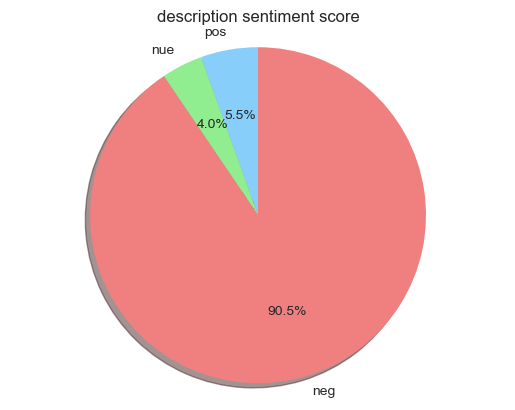

In [188]:
### Description 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
pos = len(all_data[all_data['Description_Sentiment_Score'] > 0])/len(all_data)
# 감성 점수가 0 인 경우 중립
nue = len(all_data[all_data['Description_Sentiment_Score'] == 0])/len(all_data)
# 감성 점수가 0 이하의 경우 부정
neg = len(all_data[all_data['Description_Sentiment_Score'] < 0])/len(all_data)
# 출력확인
print("긍정비율",pos)
print("중립비율",nue)
print("부정비율",neg)

# 긍정부정중립 비율 그래프
colors = [ 'lightskyblue','lightgreen','lightcoral',]

plt.title('description sentiment score')

plt.pie([pos,nue,neg], labels = ['pos','nue','neg'], autopct='%1.1f%%', startangle=90, colors = colors, shadow=True)
plt.axis('equal')

# 그래프 보여주기
plt.show()

긍정비율 0.012804097311139564
중립비율 0.9282970550576184
부정비율 0.058898847631242


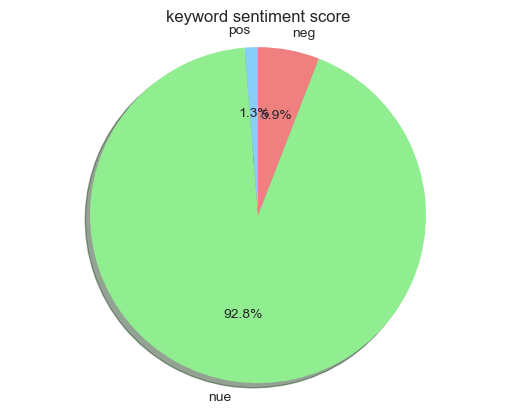

In [189]:
### Keywords 기준 감성 점수의 비율 ###

# 감성 점수가 0 이상의 경우 긍정
key_pos = len(all_data[all_data['Keywords_Sentiment_Score'] > 0])/len(all_data)
# 감성 점수가 0 인 경우 중립
key_nue = len(all_data[all_data['Keywords_Sentiment_Score'] == 0])/len(all_data)
# 감성 점수가 0 이하의 경우 부정
key_neg = len(all_data[all_data['Keywords_Sentiment_Score'] < 0])/len(all_data)
# 출력확인
print("긍정비율",key_pos)
print("중립비율",key_nue)
print("부정비율",key_neg)

# 긍정부정중립 비율 그래프
plt.title('keyword sentiment score')

plt.pie([key_pos,key_nue,key_neg], labels = ['pos','nue','neg'], autopct='%1.1f%%', startangle=90,colors = colors,shadow=True)
plt.axis('equal')

# 그래프 보여주기
plt.show()